In [4]:
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import scipy.stats as st
from functools import reduce
%matplotlib inline
from collections import Counter

In [5]:
cn = pd.read_csv("/Users/estelleyao/Downloads/CCLE_gene_cn.csv")
exp = pd.read_csv("/Users/estelleyao/Downloads/CCLE_expression.csv")
info = pd.read_csv("/Users/estelleyao/Downloads/sample_info.csv")
gene_locus = pd.read_csv("/Users/estelleyao/Downloads/sort_gene_locus.csv", sep= "\t")

In [6]:
cn.index = cn['Unnamed: 0']
cn = cn.drop(columns = ['Unnamed: 0'])

exp.index = exp['Unnamed: 0']
exp = exp.drop(columns = ['Unnamed: 0'])

inter, ind1, ind2 = np.intersect1d(cn['Unnamed: 0'], exp['Unnamed: 0'],  return_indices=True)

exp_clean = exp.iloc[ind2,:]
cn_clean = cn.iloc[ind1,:]

cn_colnames = [re.sub(" ","",re.sub("[\(\[].*?[\)\]]", "", c)) for c in cn_clean.columns] 
exp_colnames = [re.sub(" ","",re.sub("[\(\[].*?[\)\]]", "", c)) for c in exp_clean.columns] 

exp_clean.columns = exp_colnames
cn_clean.columns = cn_colnames

cn_T = cn_clean.T
cn_T.columns = cn_T.iloc[0,:]
cn_T = cn_T.iloc[1:,:]

In [9]:
def intersect_remove_HLA(df_cn, df_expr, df_metadata, df_locus):
    
    df_metadata = df_metadata.loc[~pd.isnull(df_metadata["CCLE_Name"])]
    
    df_cn = df_cn.loc[np.intersect1d(df_cn.index, df_metadata["DepMap_ID"])]
    
    # keep cell lines present in both dataframes because df_cn is the ground truth and df_expr is what we're inferring CN from
    df_cn_keep = df_cn.loc[np.intersect1d(df_cn.index, df_expr.index), np.intersect1d(df_cn.columns, df_expr.columns)]
    df_expr_keep = df_expr.loc[np.intersect1d(df_cn.index, df_expr.index), np.intersect1d(df_cn.columns, df_expr.columns)]
     
    genes, entrez_id = list(zip(*df_expr_keep.columns.str.split(" ")))
    
    # simplify column names
    df_expr_keep.columns = genes
    df_cn_keep.columns = genes    

    # remove HLA genes like they did in their workflow
    df_cn_keep = df_cn_keep.loc[:, ~df_cn_keep.columns.str.contains("HLA")]
    df_expr_keep = df_expr_keep.loc[:, ~df_expr_keep.columns.str.contains("HLA")]
    
    common_genes = reduce(np.intersect1d, (df_cn_keep.columns, df_expr_keep.columns, df_locus["HGNC.symbol"].values))

    df_expr_keep = df_expr_keep[common_genes]
    df_cn_keep = df_cn_keep[common_genes]
    
    # this one is a little longer than the others because there are some repeated genes
    df_locus_keep = df_locus.loc[df_locus["HGNC.symbol"].isin(common_genes), :]
    
    # keep only the metadata rows (cell lines) in df_cn_keep
    df_metadata_keep = df_metadata.loc[(df_metadata["DepMap_ID"].isin(df_cn_keep.index))]
    
    return df_cn_keep-1, df_expr_keep, df_metadata_keep.reset_index(drop=True), df_locus_keep

In [10]:
CN, expr, metadata, gene_loci = intersect_remove_HLA(cn, exp, info, gene_locus)

In [11]:
rel_expr = (expr-expr.mean())

# replace values outside the range (-3, 3) with -3 or 3, as they did in the paper
rel_expr = rel_expr[(rel_expr <= 3)].fillna(3)
rel_expr = rel_expr[(rel_expr >= -3)].fillna(-3)

# sort genes by their chromosomal location -- first by chromosome, then by the karyotype band
# alternating light and dark stripes that appear along the lengths of chromosomes. Each chromosome has a unique banding pattern, so band is another location along a chromosome
sorted_genes = gene_loci.sort_values(by=["Chromosome.scaffold.name", 
                                         "Karyotype.band"])["HGNC.symbol"].drop_duplicates().values

In [12]:
def highest_genes(num_highest):
    
    # indices of highest average relative gene expression, take 1000
    indices_highest = np.argsort(rel_expr.mean()).values[::-1][:num_highest]

    # get the high genes from just one dataframe (because they are all in the same order)
    high_genes = rel_expr.iloc[:, indices_highest].columns

    # arrange the high genes according to chromosomal order
    sorted_genes_high = [gene for gene in sorted_genes if gene in high_genes]

    # rearrange dataframes according to chromosomal order
    RE_high = rel_expr[sorted_genes_high]
    expr_high = expr[sorted_genes_high]
    CN_high = CN[sorted_genes_high]
    
    return RE_high, expr_high, CN_high

In [13]:
RE_high, expr_high, CN_high = highest_genes(7000)

# make a dictionary mapping each gene to the chromosomal arm it's in
gene_arm_dict = dict(zip(gene_loci["HGNC.symbol"], gene_loci["chr.arm"]))
chr_arms = [gene_arm_dict[gene] for gene in CN_high.columns]

chr_arms_df = pd.DataFrame(chr_arms).T
chr_arms_df.columns = CN_high.columns

CN_high = CN_high.append(chr_arms_df).rename(index={0: "chr_arm"})

CN_transposed = CN_high.T.convert_dtypes()

# replace single digit numbers with 0 followed by number to sort properly
split_names = CN_transposed["chr_arm"].str.split('(\d+)').values
arms = [name[-1] for name in split_names]
chroms = ["0" + name[1] if len(name[1]) == 1 else name[1] for name in split_names]

new_names = [chrom + arm for chrom, arm in zip(chroms, arms)]
CN_transposed["chr_arm"] = new_names

RE_transposed = RE_high.T
RE_transposed["chr_arm"] = new_names

grouped_CN = CN_transposed.groupby("chr_arm").mean()

In [14]:
df_hm = grouped_CN.T
df_hm["tissue_type"] = metadata['primary_disease'].values

In [49]:
from sklearn.cross_decomposition import CCA
from scipy.stats import pearsonr

In [16]:
cca = CCA(n_components=5)

In [17]:
cca.fit(df_hm.drop(columns = ['tissue_type']), expr)

CCA(n_components=5)

In [18]:
CN_c, EXP_c = cca.transform(df_hm.drop(columns = ['tissue_type']), expr)

In [19]:
cca_score = cca.score(df_hm.drop(columns = ['tissue_type']), expr)

In [75]:
cellline = pd.DataFrame(CN_c)
cellline['type'] = df_hm['tissue_type'].values
cellline['plot_type'] = cellline['type']
cellline.loc[~cellline['plot_type'].isin(['Skin Cancer','Head and Neck Cancer','Leukemia','Bile Duct Cancer', 
                                          'Gastric Cancer','Ovarian Cancer',
                                          'Brain Cancer','Lung Cancer','Breast Cancer','Kidney Cancer']),'plot_type'] = "Others"

/Users/estelleyao/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 26.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


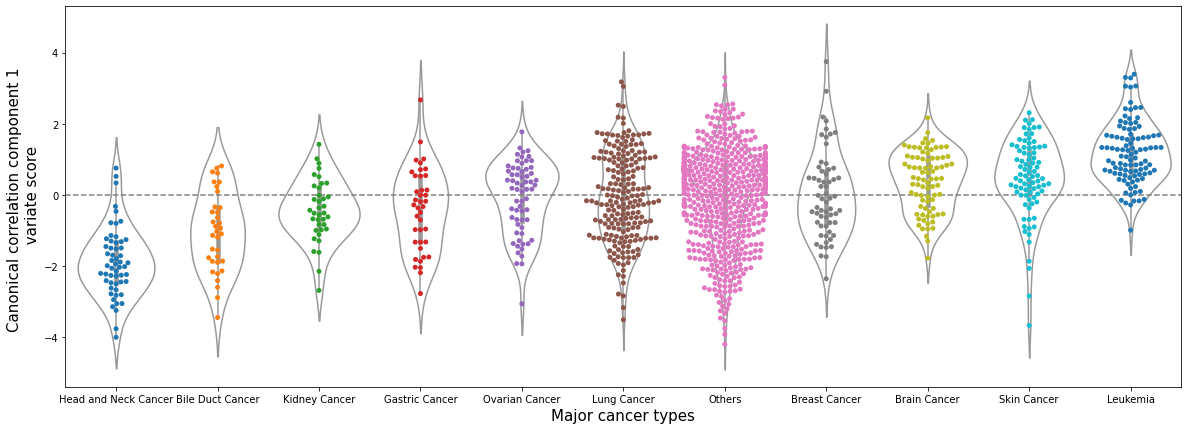

In [76]:
cellline['plot_type'] = cellline['type']
cellline.loc[~cellline['plot_type'].isin(['Skin Cancer','Head and Neck Cancer','Leukemia','Bile Duct Cancer', 
                                          'Gastric Cancer','Ovarian Cancer',
                                          'Brain Cancer','Lung Cancer','Breast Cancer','Kidney Cancer']),'plot_type'] = "Others"

cellline.plot_type = pd.Categorical(cellline.plot_type, 
                                    ordered=True, 
                                    categories=(cellline.groupby(by = "plot_type").mean().sort_values(by = 0)).index)

plt.subplots(figsize = (20,7))
sns.violinplot(data = cellline, x = "plot_type", y =0, color = "white")
sns.swarmplot(data = cellline, x = "plot_type", y =0, palette = 'tab10')
plt.axhline(y = 0 , ls = "--", color = "grey")
plt.xlabel("Major cancer types", size = 15)
plt.ylabel("Canonical correlation component 1 \n variate score", size = 15)
plt.savefig("CCA_comp1.png")
plt.show()

/Users/estelleyao/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 37.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


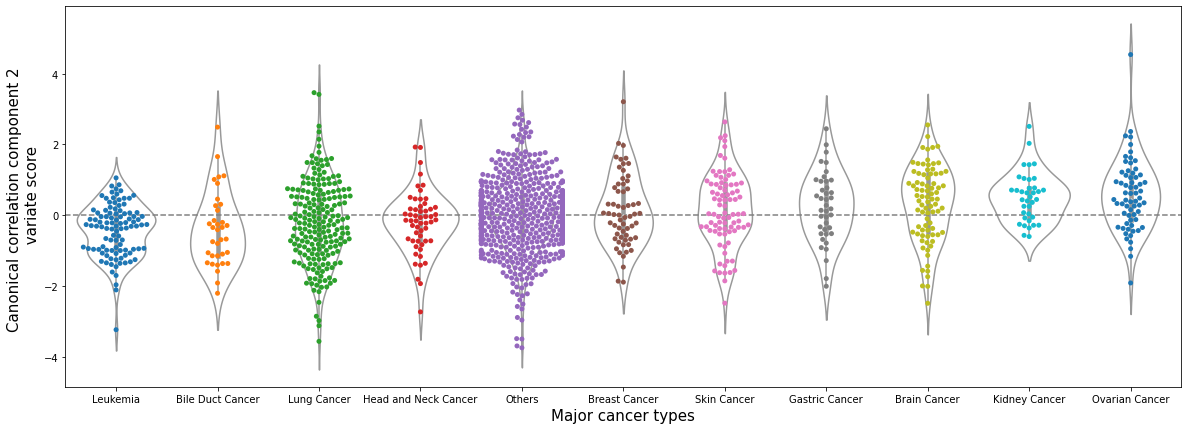

In [46]:
cellline['plot_type'] = cellline['type']
cellline.loc[~cellline['plot_type'].isin(['Skin Cancer','Head and Neck Cancer','Leukemia','Bile Duct Cancer', 
                                          'Gastric Cancer','Ovarian Cancer',
                                          'Brain Cancer','Lung Cancer','Breast Cancer','Kidney Cancer']),'plot_type'] = "Others"

cellline.plot_type = pd.Categorical(cellline.plot_type, 
                                    ordered=True, 
                                    categories=(cellline.groupby(by = "plot_type").mean().sort_values(by = 1)).index)

plt.subplots(figsize = (20,7))
sns.violinplot(data = cellline, x = "plot_type", y =1, color = "white")
sns.swarmplot(data = cellline, x = "plot_type", y =1, palette = 'tab10')
plt.axhline(y = 0 , ls = "--", color = "grey")
plt.xlabel("Major cancer types", size = 15)
plt.ylabel("Canonical correlation component 2 \n variate score", size = 15)
plt.show()

In [78]:
cor1,cor2 = [],[]
for c in df_hm.columns[:-1]:
    p1 = pearsonr(df_hm[c], CN_c[:,0])[0]
    p2 = pearsonr(df_hm[c], CN_c[:,1])[0]
    cor1.append(p1)
    cor2.append(p2)

In [79]:
cross_cn = pd.DataFrame({'chr_arm':df_hm.columns[:-1] ,
              'cross_loading1': cor1, 
              'cross_loading2': cor2
             }).sort_values(by = "cross_loading1")

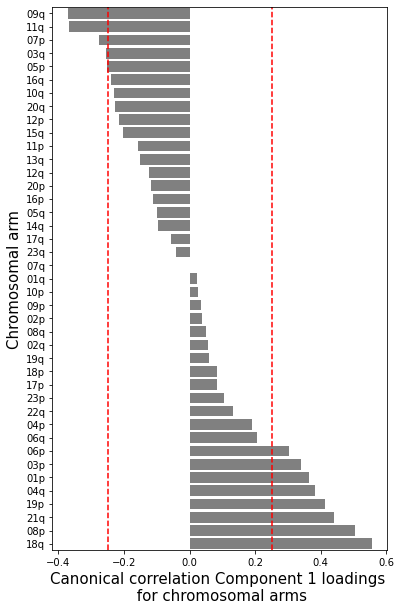

In [81]:
plt.subplots(figsize= (6,10))
sns.barplot(data = cross_cn, y = "chr_arm", x = "cross_loading1", color = "grey")
plt.xlabel('Canonical correlation Component 1 loadings \n for chromosomal arms', size= 15)
plt.ylabel("Chromosomal arm", size = 15)
plt.axvline(x = 0.25, ls = "--", color= "red")
plt.axvline(x = - 0.25, ls = "--", color = "red")
plt.savefig("CCA1_loading.png")
plt.show()


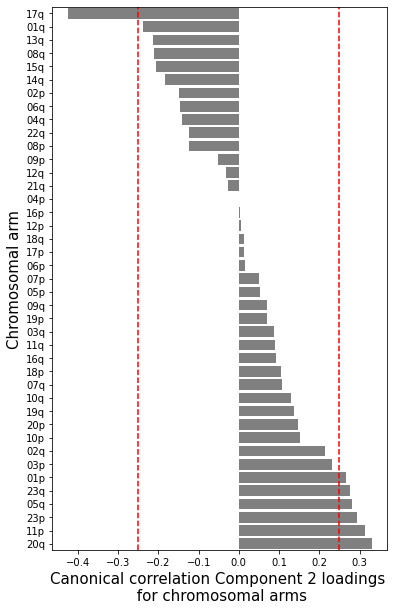

In [66]:
plt.subplots(figsize= (6,10))
sns.barplot(data = cross_cn, y = "chr_arm", x = "cross_loading2", color = "grey")
plt.xlabel('Canonical correlation Component 2 loadings \n for chromosomal arms', size= 15)
plt.ylabel("Chromosomal arm", size = 15)
plt.axvline(x = 0.25, ls = "--", color= "red")
plt.axvline(x = - 0.25, ls = "--", color = "red")


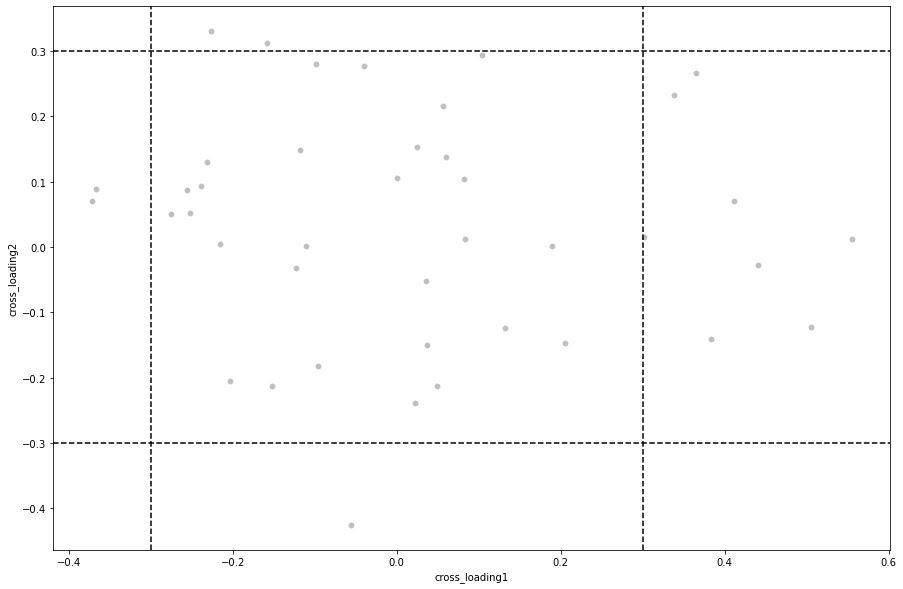

In [52]:
plt.subplots(figsize=(15,10))

sns.scatterplot(data = cross_cn, x = "cross_loading1", y ="cross_loading2", 
                alpha = 0.5, color = "grey", )

plt.axvline(x = 0.3, ls = "--", color = "black")
plt.axvline(x = -0.3, ls = "--", color = "black")
plt.axhline(y = 0.3, ls = "--", color = "black")
plt.axhline(y = -0.3, ls = "--", color = "black")

plt.show()

In [67]:
cor1,cor2 = [],[]
for c in expr.columns:
    p1 = pearsonr(expr[c], EXP_c[:,0])[0]
    p2 = pearsonr(expr[c], EXP_c[:,1])[0]
    cor1.append(p1)
    cor2.append(p2)

In [68]:
cross_exp = pd.DataFrame({'chr_arm':expr.columns ,
              'cross_loading1': cor1, 
              'cross_loading2': cor2
             }).sort_values(by = "cross_loading1")

In [71]:
rank = cross_exp[["chr_arm","cross_loading1"]]
rank.columns= ['gene','score']

In [74]:
rank.to_csv("rn_bulk.rnk", sep="\t", index= None)

In [103]:
leading_edge1 = pd.read_csv("/Users/estelleyao/Downloads/GOBP_KERATINIZATION.tsv",sep="\t")
leading_edge2 = pd.read_csv("/Users/estelleyao/Downloads/GOBP_KERATINOCYTE_DIFFERENTIATION.tsv",sep="\t")

In [106]:
leading_edge = leading_edge1.append(leading_edge2).drop_duplicates(subset= ['SYMBOL'])
leading_edge[leading_edge[ 'CORE ENRICHMENT'] =="Yes"]

,NAME,SYMBOL,RANK IN GENE LIST,RANK METRIC SCORE,RUNNING ES,CORE ENRICHMENT,Unnamed: 6
11,row_11,CSTA,6511,-0.298604,-0.860245,Yes,NaN
12,row_12,KRT14,6545,-0.307766,-0.842202,Yes,NaN
13,row_13,KRT23,6597,-0.335860,-0.824718,Yes,NaN
14,row_14,KLK5,6635,-0.359348,-0.803425,Yes,NaN
15,row_15,KRT7,6675,-0.382264,-0.780722,Yes,NaN
16,row_16,PI3,6690,-0.398481,-0.753132,Yes,NaN
17,row_17,DSC2,6701,-0.410497,-0.724059,Yes,NaN
18,row_18,KRT5,6710,-0.416561,-0.694241,Yes,NaN
19,row_19,KRT17,6716,-0.421288,-0.663629,Yes,NaN
20,row_20,KRT16,6720,-0.424450,-0.632488,Yes,NaN


In [110]:
cross_exp['enrich'] = cross_exp.chr_arm.isin(leading_edge.SYMBOL)

In [138]:
gene_list = ['PKP3','KRT6A','ANXA1','ZBED2','AQP3','SFN','KRT8','KRT15','KRT18']

In [139]:
cross_exp['label'] = ""
cross_exp.loc[cross_exp['chr_arm'].isin(gene_list),'label'] = cross_exp.loc[cross_exp['chr_arm'].isin(gene_list),'chr_arm']

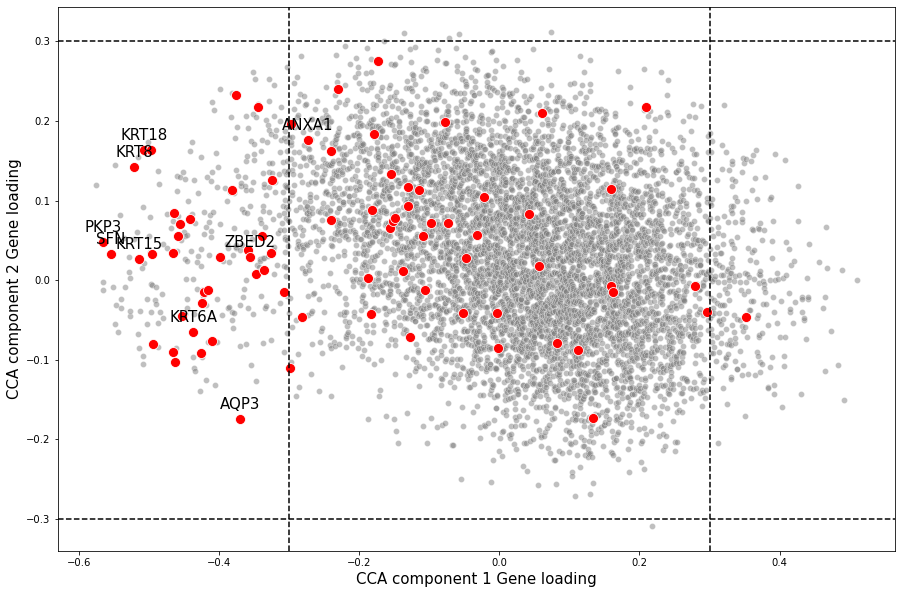

In [143]:
plt.subplots(figsize=(15,10))

sns.scatterplot(data = cross_exp, x = "cross_loading1", y ="cross_loading2", alpha = 0.5, color = "grey")
sns.scatterplot(data = cross_exp[cross_exp['enrich'] == True], x = "cross_loading1", y ="cross_loading2", 
                alpha = 1, color = "red", s = 100)

plt.axvline(x = 0.3, ls = "--", color = "black")
plt.axvline(x = -0.3, ls = "--", color = "black")
plt.axhline(y = 0.3, ls = "--", color = "black")
plt.axhline(y = -0.3, ls = "--", color = "black")

for g, x,y in zip(cross_exp[cross_exp['enrich'] == True]['label'],
                cross_exp[cross_exp['enrich'] == True]['cross_loading1'],
               cross_exp[cross_exp['enrich'] == True]['cross_loading2']):


    plt.annotate(g, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center',size= 15) # horizontal alignment can be left, right or center

plt.xlabel("CCA component 1 Gene loading", size = 15)
plt.ylabel("CCA component 2 Gene loading", size = 15)
plt.savefig("CCA_gene.png")
plt.show()

In [87]:
gs = pd.read_csv("/Users/estelleyao/Downloads/gsea_report_for_na_neg_1638320568268.tsv",sep="\t")

In [147]:
gs_pos = pd.read_csv("/Users/estelleyao/Downloads/gsea_report_for_na_pos_1638320568268.tsv",sep="\t")

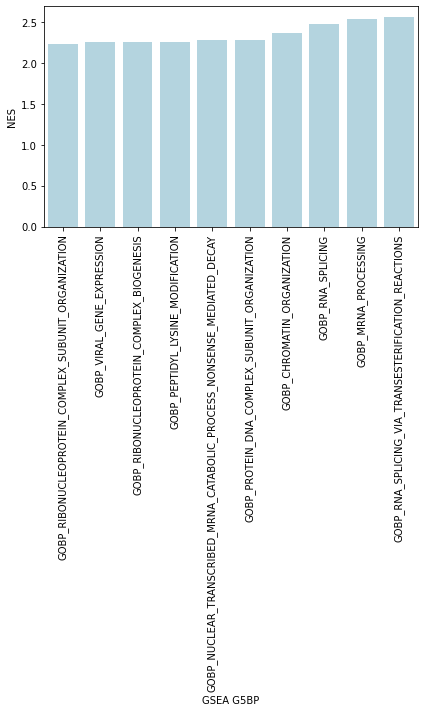

In [156]:
plt.subplots(figsize=(6,10))
sns.barplot(data = gs_pos.iloc[:10].sort_values(by = "NES"), x = "NAME", y ="NES", color = "lightblue")
plt.xticks(rotation = 90)
plt.xlabel("GSEA G5BP")
plt.tight_layout()
plt.savefig("pos_path.png")
plt.show()

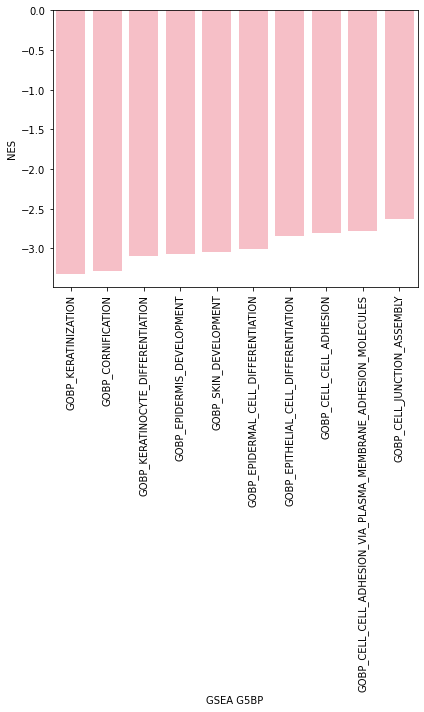

In [154]:
plt.subplots(figsize=(6,10))
sns.barplot(data = gs.iloc[:10], x = "NAME", y ="NES", color = "lightpink")
plt.xticks(rotation = 90)
plt.xlabel("GSEA G5BP")
plt.tight_layout()
plt.savefig("neg_path.png")
plt.show()

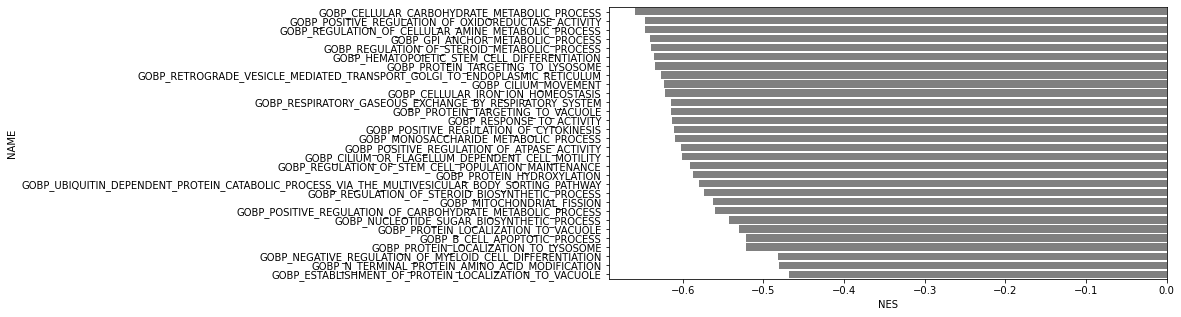

In [94]:
plt.subplots(figsize=(10,5))
sns.barplot(data = gs.iloc[-30:], y = "NAME", x ="NES", color = "grey")
plt.show()

In [189]:
pd.DataFrame(cca.y_loadings_, index = expr.columns).sort_values(by = 0)[:30]

,0,1,2,3,4
C19orf33,-0.169329,0.054020,-0.040386,-0.005845,-0.050782
ITGB4,-0.166410,-0.001273,-0.034955,-0.002522,-0.043869
PKP3,-0.166172,0.021536,-0.041437,-0.017164,-0.052012
GJB3,-0.166052,-0.005325,-0.010864,-0.002946,-0.013485
SFN,-0.162948,0.014894,-0.042560,-0.007974,-0.049683
COL17A1,-0.162011,-0.003632,-0.014477,0.005426,0.011632
TINAGL1,-0.161305,0.065419,-0.038723,0.011134,-0.032119
PRSS22,-0.161003,-0.024908,-0.030455,-0.023398,-0.029902
MPZL2,-0.160687,-0.013974,-0.014827,-0.012388,-0.038789
LAD1,-0.159897,-0.029442,-0.025273,-0.025443,-0.043658
